In [1]:
import plotly.graph_objs as go
import pandas as pd
from plotly.offline import iplot
import numpy as np
import statistics 
import plotly.express as px
from numpy.lib import recfunctions as rfn

In [4]:
e7_t01_rawCount_data = pd.read_csv("/Users/krilowcn/Desktop/Projects/GSIS/data/normalizedData/200613_E7_logNorm/200613_T01_logNorm.csv.gz", sep=",", index_col=0,low_memory=False) #pandas DataFrame
e7_t02_rawCount_data = pd.read_csv("/Users/krilowcn/Desktop/Projects/GSIS/data/normalizedData/200613_E7_logNorm/200613_T02_logNorm.csv.gz", sep=",", index_col=0,low_memory=False) #pandas DataFrame
cell_types = pd.read_csv("/Users/krilowcn/Desktop/Projects/GSIS/data/normalizedData/200613_E7_logNorm/200613_E7_cell_type.txt", sep="\t") #pandas DataFrame for cell types

In [5]:
cell_types_list = ['Alpha','Beta','Delta','Gamma','Epsilon'] #the cell types of interest for this work
cell_types = cell_types[cell_types['CellType'].isin(cell_types_list)] # parsing sampele type list, to only contain the cell types of interest
cell_types.reset_index(drop=True, inplace=True)


updated_list = []
for t in cell_types['SampleID'].values:
    if t in ['T01', 'T02']:
        updated_list.append('TP-1')
    elif t in ['T04','T05']:
        updated_list.append('TP-2')
    elif t in ['T07','T08','T09','T10']:
        updated_list.append('TP-3')
    elif t in ['T11','T13']:
        updated_list.append('TP-4')
    elif t in ['T15','T16','T17','T18']:
        updated_list.append('TP-5')
    elif t in ['T20','T21','T22']:
        updated_list.append('TP-6')
    else:
        updated_list.append('NA')
        
cell_types['TimePoint'] = updated_list

cell_types

CellID SampleID CellType TimePoint
0      AAACCTGGTAGCCTAT-1      T01    Alpha      TP-1
1      AAACCTGTCAAACGGG-1      T01    Alpha      TP-1
2      AAACGGGCAGTATGCT-1      T01    Alpha      TP-1
3      AAAGATGAGGATGGTC-1      T01    Alpha      TP-1
4      AAAGATGGTTAAGGGC-1      T01    Alpha      TP-1
...                   ...      ...      ...       ...
24700  TTCTACAGTGAGGCTA-1      T22    Gamma      TP-6
24701  TTCTTAGGTTGAGTTC-1      T22    Gamma      TP-6
24702  TTGGAACCACATAACC-1      T22    Gamma      TP-6
24703  TTTCCTCCAATCGGTT-1      T22    Gamma      TP-6
24704  TTTCCTCCATGGAATA-1      T22    Gamma      TP-6

[24705 rows x 4 columns]

In [6]:
# Data dict
sample_dict = {
    'T01': pd.read_csv("/Users/krilowcn/Desktop/Projects/GSIS/data/normalizedData/200613_E7_logNorm/200613_T01_logNorm.csv.gz", sep=",", index_col=0,low_memory=False), #pandas DataFrame,
    'T02': pd.read_csv("/Users/krilowcn/Desktop/Projects/GSIS/data/normalizedData/200613_E7_logNorm/200613_T02_logNorm.csv.gz", sep=",", index_col=0,low_memory=False) #pandas DataFrame
}

In [10]:
# print(sample_dict)

In [7]:
cells = pd.DataFrame([], columns = ['gene', 'mean_expr_1', 'mean_expr_2', 'cell_type', 'time_point'])

for cell_type in np.unique(cell_types['CellType']):
    if cell_type == "unknown":
        continue
    sub_cells = cell_types[cell_types.CellType == cell_type]
    for time_point in np.unique(cell_types['TimePoint']):
        ## To do -- deal with High / low glucose treatment
        ## This should be a list of maximum two samples
        sampls = np.unique(cell_types[cell_types.TimePoint == time_point]['SampleID'])

        if (len(sampls) != 2):
            continue 
        ## Get sample IDs
        counts_1 = sample_dict.get(sampls[0])
        counts_2 = sample_dict.get(sampls[1])
        if counts_1 is None or counts_2 is None:
            continue
        
        barcodes_1 = sub_cells[sub_cells.SampleID == sampls[0]]['CellID'].values
        barcodes_2 = sub_cells[sub_cells.SampleID == sampls[1]]['CellID'].values
        means_1 = np.mean(counts_1.loc[:, barcodes_1],axis=1) 
        means_2 = np.mean(counts_2.loc[:, barcodes_2],axis=1)
        joint_index = np.intersect1d(means_1.index.values, means_2.index.values)

        cells = cells.append( #look at the gene name for R1 and R2, output that and compare to see if they match or not*
            pd.DataFrame({
                'gene': joint_index,
                'mean_expr_1': means_1.loc[joint_index].values,
                'mean_expr_2': means_2.loc[joint_index].values,
                'cell_type': [cell_type] * len(joint_index),
                'time_point': [time_point] * len(joint_index)
            }))

In [8]:
cells

gene  mean_expr_1  mean_expr_2 cell_type time_point
0       A1BG     0.602543     0.653069     Alpha       TP-1
1       A1CF     0.346487     0.363727     Alpha       TP-1
2        A2M     0.003385     0.000000     Alpha       TP-1
3     A4GALT     0.012006     0.013187     Alpha       TP-1
4       AAAS     0.106977     0.111613     Alpha       TP-1
...      ...          ...          ...       ...        ...
9558  ZSWIM8     0.084124     0.124572     Gamma       TP-1
9559    ZUP1     0.043171     0.037382     Gamma       TP-1
9560   ZWINT     0.007679     0.012957     Gamma       TP-1
9561  ZYG11B     0.087935     0.073875     Gamma       TP-1
9562     ZYX     0.125522     0.104687     Gamma       TP-1

[47815 rows x 5 columns]

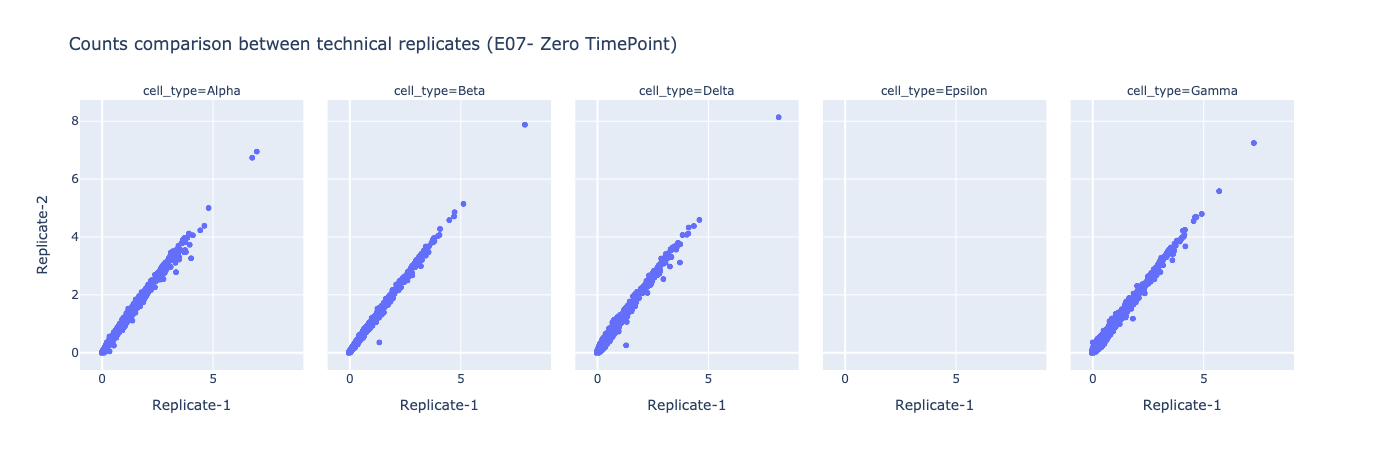

In [9]:
fig = px.scatter(cells, x="mean_expr_1", 
                 y="mean_expr_2", 
                 facet_col="cell_type",
                 hover_name=cells.gene,
                 title = 'Counts comparison between technical replicates (E07- Zero TimePoint)',
                 labels={
                     "mean_expr_1": "Replicate-1",
                     "mean_expr_2": "Replicate-2",
                 },)
fig.show()

/Users/krilowcn/anaconda3/envs/BINF/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 9563 rows containing missing values.
/Users/krilowcn/anaconda3/envs/BINF/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 9563 rows containing missing values.


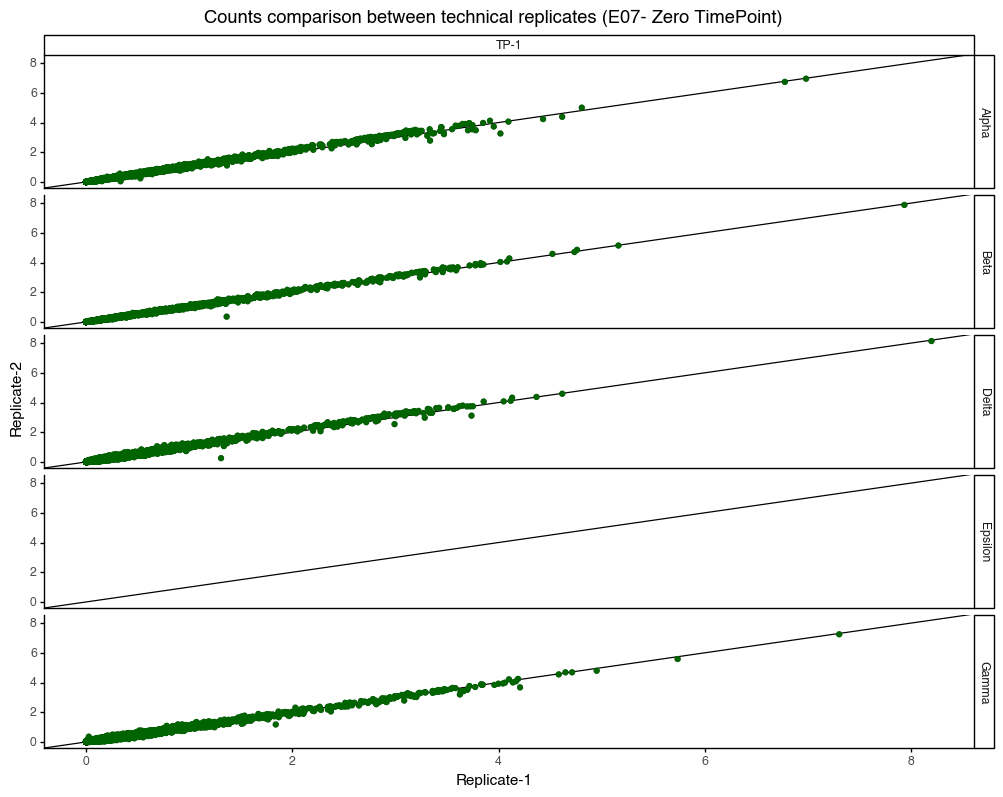

<ggplot: (8775704093257)>

In [23]:
import plotnine as plt9
from plotnine import *
from plotnine.data import *

%matplotlib inline

# plt9.options.figure_size = (6.4, 4.8) #Default Figure Size
plt9.options.figure_size = (12,9)

#AB line, set line =0 and slope =1 
# plt9.ggplot(cells, plt9.aes(x='mean_expr_1', y = 'mean_expr_2')) + plt9.geom_point() + plt9.facet_grid('cell_type ~ time_point') + plt9.theme_bw()
plt9.ggplot(cells, plt9.aes(
    x='mean_expr_1', 
    y = 'mean_expr_2')) + plt9.geom_point(
    alpha=0.50) + geom_abline(intercept=0, 
    slope=1) + plt9.facet_grid('cell_type ~ time_point') + labs(title="Counts comparison between technical replicates (E07- Zero TimePoint)",
                                                                x="Replicate-1",y="Replicate-2",size="Gene",color="Gene") + theme_classic(base_family = "Helvetica")+geom_point(color='darkgreen')
# p.save(filename = 'e07R1_R2..png', height=5, width=5, units = 'in', dpi=1000)

